TensorFlow Sandbox

In [1]:
from Learning import *
from Graphing import *

In [32]:
meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = load_ld("d2,5,12_all_30k")

In [33]:
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((29932, 26), (29932, 5622), 5622, (20, 126), 126, (29932, 13), (29932, 160))

Remove duplicates

In [4]:
if "X_rec_avgs" in locals() and X_rec_avgs.size and len(X_rec_avgs) == len(meta):
    meta, X, Yc, Yr, X_rec_avgs, X_rec = shuffle_data([meta, X, Yc, Yr, X_rec_avgs], X_rec)
else:
    meta, X, Yc, Yr, X_rec = shuffle_data([meta, X, Yc, Yr], X_rec)

In [5]:
meta, X, X_rec, Yc, Yr = remove_duplicate_players(meta, X, X_rec, Yc, Yr, meta_labels, elo_limit=None)

In [6]:
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((13701, 26), (13701, 5622), 5622, (19, 126), 126, (13701, 13), (13701, 160))

Remove redundant features

In [34]:
X, X_labels, X_rec, X_rec_labels = remove_redundant_features(X, X_labels, X_rec, X_rec_labels)

In [35]:
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((29932, 26), (29932, 3221), 3221, (20, 61), 61, (29932, 13), (29932, 160))

Exclude games for which we have no recent match history data (try including later)

In [29]:
rem_is = []
for i in range(len(meta)):
    if all([len(X_rec[i][j]) == 0 for j in N_PL_r]):
        rem_is.append(i)
len(rem_is)
meta, X, X_rec, Yc, Yr = remove_data_inds(meta, X, X_rec, Yc, Yr, rem_is)
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((14137, 26), (14137, 5622), 5622, (20, 126), 126, (14137, 13), (14137, 160))

Shuffle data

In [36]:
if "X_rec_avgs" in locals() and X_rec_avgs.size and len(X_rec_avgs) == len(meta):
    meta, X, Yc, Yr, X_rec_avgs, X_rec = shuffle_data([meta, X, Yc, Yr, X_rec_avgs], X_rec)
else:
    meta, X, Yc, Yr, X_rec = shuffle_data([meta, X, Yc, Yr], X_rec)

Data normalization/feature scaling (for data other than recent match histories)

In [37]:
print(Yr.min(), X.min(), Yr.max(), X.max()) # Scale data to between 0 & 1 (remember scaling values)
X_scales = scale_data(X, X_labels)
Yr_scales = scale_data(Yr, Yr_labels)
print(Yr.min(), X.min(), Yr.max(), X.max())

0.0 -621008.984 772455.0 1535732350807.0
0.0 0.0 1.0 1.0


In [43]:
# unscale_data(X, X_labels, X_scales) # Unscale
# unscale_data(Yr, Yr_labels, Yr_scales)
# print(Yr.min(), X.min(), Yr.max(), X.max())

(20, 126)

In [ ]:
# Get the final form of recent games data (convert queue ids etc) (for now ignore champion, spells)
X_rec, X_rec_labels = get_rec_feats(X_rec, X_rec_labels)

In [121]:
# Scale data to 0-1
X_rec = scale_rec_data(X_rec)

14136

Remove game duration (win prediction use case)

In [38]:
X, X_labels = remove_data_subset(X, X_labels, duration_labels)
X.shape

(29932, 3220)

Define experiment models & variables

In [121]:
# Y_labels = Yc_labels_all
Y_labels = ["blue_win"]
# Y_labels = ["blue_win", "blue_first_tower", "blue_first_dragon", "blue_first_inhib"]
# Y_labels = ["blue_win", "blue_first_blood", "blue_first_tower", "blue_rift_herald",
#             "blue_first_dragon", "blue_first_baron", "blue_first_inhib"]
# Y_labels_print = ["blue_win", "blue_first_tower", "blue_first_dragon", "blue_first_inhib"]
Y_labels_print = Y_labels

Y = Yc[:, [Yc_labels_all.index(l) for l in Y_labels]]
_X = X

# Convert Y to one-hot
Y = np.atleast_2d(Y).T
_Y = np.zeros((Y.size, int(Y.max()) + 1))
_Y[np.arange(Y.size), (Y).astype(np.int)] = 1
Y = _Y


# two_months_ago = (time.time() - (60 * 24.0 * 60.0 * 60.0)) * 1000 # Recent games only filter
# new_is = np.nonzero(X[:, -n_patches-n_seasons-n_regions-3] < two_months_ago)
# Y = Yc[new_is, [Yc_labels_all.index(l) for l in Y_labels]].T
# _X = X[new_is]
# _X = _X[:, :1390]

# Number of test samples
n_test = 1000
X_train, Y_train, Yr_train, X_test, Y_test = _X[:-n_test], Y[:-n_test], Yr[:-n_test], _X[-n_test:], Y[-n_test:]
n_train, n_features, n_outputs = X_train.shape[0], X_train.shape[1], Y_train.shape[1]
blue_win_perc = 100.0 * np.sum(Y[:, 0]) / Y.shape[0] # Check blue win percentage
Y_labels, _X.shape, Y.shape, n_test, blue_win_perc, n_features, n_outputs

(['blue_win'], (29932, 2092), (29932, 2), 1000, 50.99559000400909, 2092, 2)

Remove training data games where players significantly underperformed (disconnects/trolls), computed via low xp percentiles

In [122]:
perc = 0.5
perf_measure = "xp_10min"
rem_is = []
for r in t_roles:
    val_i = Yr_labels.index(r + '_' + perf_measure)
    perc_val = np.percentile(Yr_train[:, val_i], perc)
    rem_is.append(Yr_train[:, val_i] < perc_val)
rem_is = np.nonzero(np.logical_or.reduce(rem_is))[0]
X_train = np.delete(X_train, rem_is, axis=0)
Y_train = np.delete(Y_train, rem_is, axis=0)
n_train = X_train.shape[0]
X_train.shape, Y_train.shape

((27590, 2092), (27590, 2))

Filter test data to test prediction for games above an elo skill rating of ```elo_N```

In [123]:
elo_N = 2400
test_is = np.nonzero(meta[2000:, meta_labels.index("elo")] > elo_N)[0]
len(test_is)
# X_test, Y_test = X_test[test_is], Y_test[test_is]
# X_test.shape, Y_test.shape

2657

Fit, train & test models, save result (naming format: predictions_startNumSamples_endNumSamples_numEvalSamples_featuresUsed)

Epoch 500 : 0.98695177 0.875 344.17877


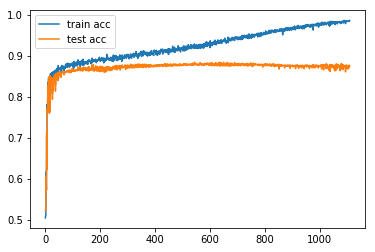

In [136]:
import tensorflow as tf
from IPython.display import clear_output

# Define next batch function
current_i, epochs_completed = 0, 0
def next_batch(b_size):
    global current_i, epochs_completed
    xs, ys = X_train[current_i:current_i + b_size], Y_train[current_i:current_i + b_size]
    current_i += b_size
    if current_i >= n_train:
        current_i = 0
        epochs_completed += 1
    return xs, ys

train_set_test_frac = 0.2 # Get training accuracy for random 20% subset of train set
log_period_batches = 50
n_epochs = 500
learning_rate = 0.000002
learning_rate_gd = 0.01
dropout_keep_prob = 0.85
batch_size = 250
l1_n_units = 1024
l2_n_units = 1024
l3_n_units = 1024
# l4_n_units = 1024
# l5_n_units = 1024
# l6_n_units = 1024

n_train_test = int(train_set_test_frac * n_train)
izer = tf.contrib.layers.xavier_initializer()
tf.reset_default_graph()
train_accuracy, test_accuracy, test_loss = [], [], []

x = tf.placeholder(tf.float32, [None, n_features])
y = tf.placeholder(tf.float32, [None, n_outputs])
keep_prob = tf.placeholder(tf.float32)

W_1 = tf.Variable(izer([n_features, l1_n_units]))
b_1 = tf.Variable(izer([l1_n_units]))
W_2 = tf.Variable(izer([l1_n_units, l2_n_units]))
b_2 = tf.Variable(izer([l2_n_units]))
W_3 = tf.Variable(izer([l2_n_units, l3_n_units]))
b_3 = tf.Variable(izer([l3_n_units]))
W_4 = tf.Variable(izer([l3_n_units, n_outputs]))
b_4 = tf.Variable(izer([n_outputs]))
# W_5 = tf.Variable(izer([l4_n_units, l5_n_units]))
# b_5 = tf.Variable(izer([l5_n_units]))
# W_6 = tf.Variable(izer([l5_n_units, l6_n_units]))
# b_6 = tf.Variable(izer([l6_n_units]))
# W_7 = tf.Variable(izer([l6_n_units, n_outputs]))
# b_7 = tf.Variable(izer([n_outputs]))

relu_1 = tf.nn.relu(tf.matmul(x, W_1) + b_1)
# relu_2 = tf.layers.batch_normalization(tf.nn.relu(tf.matmul(relu_1, W_2) + b_2))
relu_2 = tf.nn.dropout(tf.nn.relu(tf.matmul(relu_1, W_2) + b_2), keep_prob)
# relu_2 = tf.nn.relu(tf.matmul(relu_1, W_2) + b_2)
relu_3 = tf.nn.relu(tf.matmul(relu_2, W_3) + b_3)
# relu_3 = tf.nn.dropout(tf.nn.relu(tf.matmul(relu_2, W_3) + b_3), keep_prob)
# relu_4 = tf.nn.relu(tf.matmul(relu_3, W_4) + b_4)
# relu_5 = tf.nn.relu(tf.matmul(relu_4, W_5) + b_5)
# relu_6 = tf.nn.relu(tf.matmul(relu_5, W_6) + b_6)
# drop_out = tf.nn.dropout(relu_2, keep_prob)
# y_out = tf.matmul(drop_out, W_3) + b_3
y_out = tf.matmul(relu_3, W_4) + b_4
#   y_prob = tf.nn.softmax(y_out)

# Define loss function & training step
cross_entropy = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_out))
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)
# train_step = tf.train.GradientDescentOptimizer(learning_rate_gd).minimize(cross_entropy)

# Define accuracy computation
correct = tf.equal(tf.argmax(y_out, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# Train
i = 0
with tf.train.MonitoredSession() as sess:
    while epochs_completed < n_epochs:
        
        i += 1
        batch_xs, batch_ys = next_batch(batch_size)
#         sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})
        sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout_keep_prob})

        if i % log_period_batches == 0:

            # Get random sample of 20% of the training dataset
            indices = np.random.choice(n_train, n_train_test, replace=False)
            train_accuracy += [ sess.run(accuracy, feed_dict={x: X_train[indices], y: Y_train[indices], keep_prob: 1.0}) ]

            test_l, test_a = sess.run([cross_entropy, accuracy], feed_dict={x: X_test, y: Y_test, keep_prob: 1.0})
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]
            
            clear_output()
            print("Epoch", epochs_completed, ':', train_accuracy[-1], test_a, test_l)
            fig = plt.figure()
#             ax = plt.gca()
            g = fig.add_subplot(1,1,1)
#             plt.close()
#             g.clear()

            g.plot(train_accuracy, label='train acc')
            g.plot(test_accuracy, label='test acc')
#             handles, labels = ax.get_legend_handles_labels()
            g.legend(loc='upper left')
            plt.show()

In [97]:
# # Merge champion representations ( doesn't improve anything ):
# top_champ_is = {}
# top_champ_is["blue"] = [i for i in range(len(X_labels)) if "blue_top_champion__x" in X_labels[i]]
# top_champ_is["red"] = [i for i in range(len(X_labels)) if "red_top_champion__x" in X_labels[i]]
# rem_is = []
# for side in cols_all:
#     for role in ['jungle', 'middle', 'support', 'adc']:
#         r = side + '_' + role
#         r_champ_is = [i for i in range(len(X_labels)) if r + "_champion__x" in X_labels[i]]
#         rem_is += r_champ_is
#         X[top_champ_is[side]] += X[r_champ_is]
# X = np.delete(X, rem_is, axis=1)
# X_labels = [X_labels[i] for i in range(len(X_labels)) if i not in rem_is]

In [1]:
# todo:
#     multitask learning with:
#             (for each player)
#         total_damage_dealt_to_champions
#         total_time_crowd_control_dealt ?
#         time_ccing_others
#         gold
#         gold_10min
#         xp_10min
        
#         first_tower
#         first_dragon
#         first_inhib ?
#         blue_win
        
#         = 64 targets, 16 if we use team totals
        
#     RNNs for recent matches
    
#     Ensemble with logistic regression & adaboost forest

SyntaxError: invalid syntax (<ipython-input-1-23ca7dbcbdea>, line 1)